### 1. Installing and importing all necessary dependencies ###

In [ ]:
#pip install gym[atari]
#pip install ale_py
#pip install autorom[accept-rom-license]
#pip install torch

In [1]:
import gym

### 2. Creating our environment ###
By using the function gym.make() we create our environment. We pass the following parameters to the function: 
| Parameter | Value | Explanation |
| :--- | :----: | :--- |
| name | "ALE/Freeway-v5" | This is the name of our game. We are using the newest version v5. ALE (Arcade Learning Environment) is a framework used to develop AI agents for Atari games. |
| difficulty | 1 | The game provides two different difficulties. By setting the difficulty to 1, the chicken is moved back to the start after each collision. Using difficulty 0, it is only thrown back. |
| mode |  | The game provides eight different modes. As the value increases, so does the number and the speed of the cars. |
| obs_type |  | This argument determines what observations are returned by the environment. We can choose from rgb, greyscale and ram. |
| frameskip |  | This argument influences frame skipping (for more information read the paragraph stochasticity) |
| repeat_action_probability |  | This argument sets the probability for sticky actions (for more information read the paragraph stochasticity) |
| render_mode |  | By setting the render mode to "human" the game will be displayed while its running. During the training of the agent, we are not going to display the game. |

In [3]:
env = gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "rgb", frameskip = 1, repeat_action_probability = 0 render_mode = "human")

#### Observation space ####

In [4]:
observation_space = env.observation_space
print("Our environment returns the following observation: {}".format(observation_space))
print("Since {} is the shape of our observation space, we recieve a 210px * 160px rgb image.".format(observation_space.shape))
print("The image gets stored as a three-dimensional array. The dimensions are 210, 160 and 3.")
print("If you want to get an example of an image try printing observation_space.sample().")
#print(observation_space.sample())
print("By using the uint data type (unsinged int using 8 bits) the lowest possible entry is 0 while 255 is the highest possible entry.")

Our environment returns the following observation: Box(0, 255, (210, 160, 3), uint8)
Since (210, 160, 3) is the shape of our observation space, we recieve a 210px * 160px rgb image.
The image gets stored as a three-dimensional array. The dimensions are 210, 160 and 3.
If you want to get an example of an image try printing observation_space.sample().
By using the uint data type (unsinged int using 8 bits) the lowest possible entry is 0 while 255 is the highest possible entry.


#### Action space ####

In [7]:
action_space = env.action_space
print("Number of different possible actions we can choose from: {}".format(action_space))
print("Possible actions with corresponding values:")
print(env.unwrapped.get_action_meanings())
print("[0, 1, 2]")
print("(NOOP stands for no operation which means that the chicken does not move.)")

Number of different possible actions we can choose from: Discrete(3)
Possible actions with corresponding values:
['NOOP', 'UP', 'DOWN']
[0, 1, 2]
(NOOP stands for no operation which means that the chicken does not move.)


#### Rewards ####
Without any changes on the environment, there is only one reward. If the chickens crosses the road it recieves a reward with the value one. Except this case, there are no other rewards, neither for colliding with a car, nor for going backwards. In the following sections we will write our own reward function in order to achieve a better learning behaviour of the agent.

#### Stochasticity ####
Since Atari games are deterministic, there is a possibility that the agent just memorizes an optimal sequence of actions instead of using the observations and the reward from the environment. Due to this fact ALE uses so called sticky actions. This ensures that with a low probability the previous action is repeated. Therefore, the action chosen by the agent is not executed. By specifing the repeat_action_probality parameter during the creation of the environment, we can influence the probality of these sticky actions.  
Additionally, Gym implements frame skipping which means that in each step the action is repeated for a random number of frames. By specifing the frameskip parameter during the creation of the environment, we can influece this number of frames. Specifically, the value indicates how often an action is repeated per step. By setting this value to one, we prevent frame skipping.

### 3. First Version: Random choices ###
In this first version the agent chooses a random action from the possible actions (up, down or no operation). 

# TODO: Wahrscheinlichkeiten Anpassen #

In [6]:
import random

env.reset()
terminated = False

while(not terminated):
    #Choosing a random action
    random_action = random.choice([0, 1, 2])

    #Recieving information
    observation, reward, terminated, truncated, info = env.step(random_action)
    
    #Render the environment
    env.render()
env.close()

In [4]:
class ClipReward(gym.RewardWrapper):
    def __init__(self, env, min_reward, max_reward):
        super().__init__(env)
        self.min_reward = min_reward
        self.max_reward = max_reward
        self.reward_range = (min_reward, max_reward)
        #Initializing the position
        self.pre_position = 0

    def reward(self, reward):
        ram = env.unwrapped.ale.getRAM()
        current_position = ram[14]

        if(current_position > self.pre_pos):
            #Chicken is moving forward
            reward = 10
        elif(current_position < self.pre_pos):
            #Chicken is moving backwards
            reward = -10
        elif(current_position == 6 and self.pre_pos > 6):
            #Chicken got hit
            reward = -100
        else:
            #Chicken is not moving
            reward = 0

        self.pre_position = current_position
        return np.clip(reward, self.min_reward, self.max_reward)

In [ ]:
env = ClipReward(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "rgb", frameskip = 1, render_mode = "human"), -100, 100)
import random

env.reset()
terminated = False

while(terminated == False):
    #Choosing a random action
    random_action = random.choice([0, 1, 2])

    #Recieving information
    observation, reward, terminated, truncated, info = env.step(random_action)

    print(reward)

    #Render the environment
    env.render()
env.close()

In [10]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym

### 4. Changing the reward function ###
The game comes with a very 

In [11]:
class ClipReward(gym.RewardWrapper):
    def __init__(self, env, min_reward, max_reward):
        super().__init__(env)
        self.pre_pos = 6
        self.min_reward = min_reward
        self.max_reward = max_reward
        self.reward_range = (min_reward, max_reward)
        self.zieldurchlaeufe = 0

# Start bei 6
# Auf 8
# Dann wieder zurück, Fehler?? 

# Alternative Lösung?

    def reward(self, reward):
        ram = env.unwrapped.ale.getRAM()
        current_pos = ram[14]
        if(current_pos >= 176): #Chicken ist im Ziel
            reward = 100
            self.zieldurchlaeufe += 1
        elif(current_pos > self.pre_pos): #Chicken geht nach vorne
            reward = 1
        elif(self.pre_pos < 176): #Chicken pos. unterm Ziel
            if(current_pos == 6 and self.pre_pos > 6): #Chicken wurde Zurückgesetzt / Carcrash
                reward = -1000
            elif(current_pos < self.pre_pos): #Chicken geht zurück
                reward = -10
        else:
            reward = 0 #Chicken bleibt stehen
        self.pre_pos = current_pos
        return np.clip(reward, self.min_reward, self.max_reward)

    def getZieldurchlaeufe(self):
        return self.zieldurchlaeufe

In [12]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        #Vererbung: Aufruf des Konstruktors der Superklasse
        super(DeepQNetwork, self).__init__()
        #Speichern der übergebenen Parameter
        self.input_dims = input_dims #Dimension des Inputs
        self.fc1_dims = fc1_dims #Dimension des ersten fully connected Layer
        self.fc2_dims = fc2_dims #Dimension des zweiten fully connected Layer
        self.n_actions = n_actions #Anzahl der möglichen Aktionen

        #Lineare Transformation
        #Pro Layer wird eine lineare Transformation angewandt
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims) #* entpackt die input_dims
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        #Mean squared error loss
        self.loss = nn.MSELoss()

        #Choosing GPU if possible
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        #TODO:
        self.to(self.device)

    def forward(self, state):
        #Activation function (RELU)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        #Only applied to the first two layers, not the output
        actions = self.fc3(x)
        return actions

In [13]:
class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions, model, max_mem_size = 1000000, eps_end = 0.01, eps_dec = 1.5e-6):
        self.runs = 0
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_counter = 0
        
        self.Q_eval = model
        #self.Q_eval = DeepQNetwork(self.lr, n_actions = n_actions, input_dims = input_dims, fc1_dims = 256, fc2_dims= 256)
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype = np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype = np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype = np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype = np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype = np.bool_)
    
    def store_transition(self, state, action, reward, state_, done):
        #Memory wird wieder von vorne überschrieben, wenn voll
        index = self.mem_counter % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done

        self.mem_counter += 1
    
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            #Exploitation instead of exploration
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            #Choosing the best actionu
            action = T.argmax(actions).item()
        else:
            #Exploration instead of exploitation
            action = np.random.choice(self.action_space)

        return action

    def learn(self):
        if self.mem_counter < self.batch_size:
            #Zu Beginn ist der Speicher noch leer
            #deshalb wird der Speicher gefüllt, bevor der Agent anfängt zu lernen
            return
        
        #Gradienten werden auf null gesetzt.
        #Andernfalls werden die Gradienten in Pytorch kummuliert
        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_counter, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace = False)

        batch_index = np.arange(self.batch_size, dtype = np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0
        q_target = reward_batch + self.gamma * T.max(q_next, dim = 1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        self.runs += 1

        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    def getModel(self):
        return self.Q_eval

    def setModel(self, path):
        self.Q_eval = T.load(path)

C:\Users\Jan Felix\AppData\Local\Temp\ipykernel_13688\3759288688.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  state = T.tensor([observation]).to(self.Q_eval.device)


0
episode  0 score -12720.00 epsilon 1.00
0
episode  1 score -13320.00 epsilon 0.99
0
episode  2 score -12470.00 epsilon 0.99
0
episode  3 score -12630.00 epsilon 0.99
0
episode  4 score -13110.00 epsilon 0.98
0
episode  5 score -14010.00 epsilon 0.98
0
episode  6 score -12560.00 epsilon 0.98
0
episode  7 score -11420.00 epsilon 0.98
0
episode  8 score -11140.00 epsilon 0.97
0
episode  9 score -10970.00 epsilon 0.97
0
episode  10 score -12230.00 epsilon 0.97
0
episode  11 score -10500.00 epsilon 0.96
0
episode  12 score -12650.00 epsilon 0.96
0
episode  13 score -10210.00 epsilon 0.96
0
episode  14 score -12640.00 epsilon 0.95
0
episode  15 score -12410.00 epsilon 0.95
0
episode  16 score -13360.00 epsilon 0.95
0
episode  17 score -10980.00 epsilon 0.94
0
episode  18 score -12220.00 epsilon 0.94
0
episode  19 score -12340.00 epsilon 0.94
0
episode  20 score -11490.00 epsilon 0.94
0
episode  21 score -11270.00 epsilon 0.93
0
episode  22 score -10650.00 epsilon 0.93
0
episode  23 score -

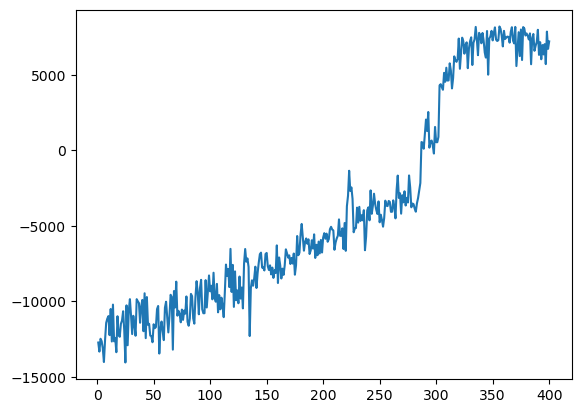

In [6]:
import gym
import numpy as np
from matplotlib import pyplot as plt

env = ClipReward(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), -100, 100)
agent = Agent(gamma = 0.99, epsilon = 1.0, batch_size = 64, n_actions = 3, eps_end = 0.01, input_dims = [128], lr = 0.003)
scores, eps_history = [], []
n_games = 400

for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()[0]
    while not done:
        action = agent.choose_action(np.float32(observation))
        #Info2 eingefügt
        observation_, reward, done, info, info2 = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)
        agent.learn()
        observation = observation_
    scores.append(score)
    eps_history.append(agent.epsilon)
    print(ClipReward.getZieldurchlaeufe(env))
    print('episode ', i, 'score %.2f' % score, 'epsilon %.2f' % agent.epsilon)
x = [i + 1 for i in range(n_games)]

T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dadajdand2')

plt.plot(x, scores)
plt.show()

# TODO: Plot mit Zieldurchläufen #
# TODO: Diagramme beschriften #
# TODO: Maximale Obergrenze berechnen und einzeichnen #

0
episode  0 score -4190.00 epsilon 0.01


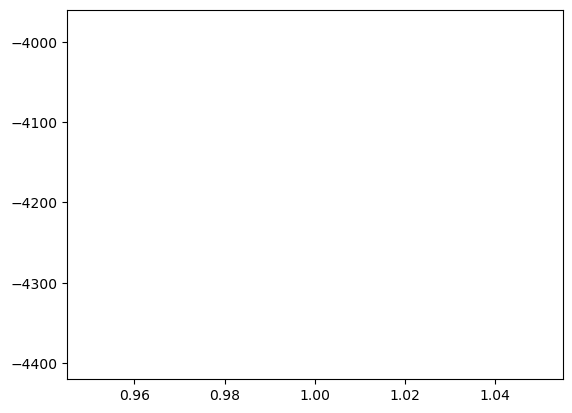

In [6]:
import numpy as np
from matplotlib import pyplot as plt

env = ClipReward(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), -100, 200)
agent = Agent(gamma = 0.99, epsilon = 1.0, batch_size = 64, n_actions = 3, eps_end = 0.01, input_dims = [128], lr = 0.003)
agent.setModel('C:\\Users\Jan Felix\Desktop\dqn_model\dadajdand')

scores, eps_history = [], []
n_games = 1

for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()[0]
    while not done:
        action = agent.choose_action(np.float32(observation))
        #Info2 eingefügt
        observation_, reward, done, info, info2 = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)
        agent.learn()
        observation = observation_
    scores.append(score)
    eps_history.append(agent.epsilon)
    print(ClipReward.getZieldurchlaeufe(env))
    print('episode ', i, 'score %.2f' % score, 'epsilon %.2f' % agent.epsilon)

x = [i + 1 for i in range(n_games)]
plt.plot(x, scores)
plt.show()


Changing the observation space

In [8]:
class RelativePosition(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = Box(shape=(2,), low=-np.inf, high=np.inf)

    def observation(self):
        ram = env.unwrapped.ale.getRAM()
        return ram[14]

In [15]:
import gym
import numpy as np
from matplotlib import pyplot as plt

env = ClipReward(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram", render_mode = "human"), -100, 100)
model = T.load('C:\\Users\Jan Felix\Desktop\dqn_model\dadajdand2')
agent = Agent(gamma = 0.99, epsilon = 0.0, batch_size = 64, n_actions = 3, eps_end = 0.01, input_dims = [128], lr = 0.003, model = model)
scores, eps_history = [], []
n_games = 400

for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()[0]
    while not done:
        action = agent.choose_action(np.float32(observation))
        #Info2 eingefügt
        observation_, reward, done, info, info2 = env.step(action)
        observation = observation_


C:\Users\Jan Felix\AppData\Local\Temp\ipykernel_12784\320751975.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  state = T.tensor([observation]).to(self.Q_eval.device)


KeyboardInterrupt: 

: 